# Exploring Cell Coverage of Routes
* To do later: move data sources to a catalog
* An agency here is defined: as a service and an operator...

In [151]:
# from shared_utils import utils
import datetime as dt
import os

# Read in zip files
import fsspec

# Warehouse
# import calitp.magics
import geopandas as gpd
import numpy as np
import pandas as pd
import shared_utils
from calitp import magics, query_sql
from calitp.tables import tbl

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils
from siuba import *

os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

In [72]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [73]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## California County Borders

In [74]:
ca_gdf = gpd.read_file(
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
)

## Trip Routes 

In [75]:
routes_df = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes.parquet"
)

In [76]:
# What does route type mean?
routes_df["route_type"].value_counts()

3    7397
2     183
0     119
4      57
5      31
1       4
Name: route_type, dtype: int64

In [77]:
cols_without_geometry = [
    "agency",
    "route_name",
    "itp_id",
    "route_id",
    "shape_id",
    "route_type",
]

In [78]:
# Drop Amtrak
routes_df2 = routes_df.loc[routes_df["agency"] != "Amtrak"]

In [79]:
# Drop Bay Area Ferry Service - ferry only
routes_df2 = routes_df2.loc[routes_df2["agency"] != "San Francisco Bay Ferry"]

In [80]:
# Maybe drop these route names:
# Tiburon to Angel Island Ferry
# Tiburon - San Francisco Ferry
# Treasure Island Ferry

In [81]:
f"{len(routes_df2)} rows left after dropping - compared to {len(routes_df)} rows before."

'7632 rows left after dropping - compared to 7791 rows before.'

In [82]:
# Fill in NA for route names and agency names
routes_df2[["agency", "route_name"]] = routes_df2[["agency", "route_name"]].fillna(
    "None"
)

In [83]:
# Keep only one instance of a unique ITP ID - Route ID - Route Type combination
routes_df3 = routes_df2.drop_duplicates(subset=["itp_id", "route_id", "route_type"])

In [84]:
# Keep only one instance of a unique ITP ID - route_name combo
routes_df3 = routes_df3.drop_duplicates(subset=["itp_id", "route_name"])

In [85]:
# Reset index after dropping
routes_df3 = routes_df3.reset_index()

In [125]:
f"{routes_df2.route_id.nunique()} unique route ids, {routes_df2.route_name.nunique()} different route names, and {routes_df2.shape_id.nunique()} different shape ids."

'1709 unique route ids, 1902 different route names, and 5924 different shape ids.'

In [87]:
routes_df3.shape

(2268, 8)

## FCC AT&T Data Map 
* Testing with AT&T first.

### Clip AT&T map to only include California Counties

In [88]:
"""
# Open zip file first
PATH = f"{GCS_FILE_PATH}ATT_Mobility_LTE_Data.zip"
with fsspec.open(PATH) as file:
    fcc_gdf = gpd.read_file(file)
    
# Check that they are the same CRS
fcc_gdf.crs == ca_gdf.crs

# Clip 
fcc_ca_gdf = gpd.clip(fcc_gdf, ca_gdf)

# Save this into a parquet so don't have to clip all the time
utils.geoparquet_gcs_export(fcc_ca_gdf, GCS_FILE_PATH, 'AT_T_Data_California_Only')
"""

'\n# Open zip file first\nPATH = f"{GCS_FILE_PATH}ATT_Mobility_LTE_Data.zip"\nwith fsspec.open(PATH) as file:\n    fcc_gdf = gpd.read_file(file)\n    \n# Check that they are the same CRS\nfcc_gdf.crs == ca_gdf.crs\n\n# Clip \nfcc_ca_gdf = gpd.clip(fcc_gdf, ca_gdf)\n\n# Save this into a parquet so don\'t have to clip all the time\nutils.geoparquet_gcs_export(fcc_ca_gdf, GCS_FILE_PATH, \'AT_T_Data_California_Only\')\n'

In [89]:
# Open
fcc_ca_gdf = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/AT_T_Data_California_Only.parquet"
)

In [124]:
# fcc_ca_gdf.plot(figsize = (30,12))

## Overlay 
* I want to obtain routes that are NOT contained in the AT & T coverage map.
* https://geopandas.org/en/stable/docs/user_guide/set_operations.html

In [127]:
# Check that they are the same CRS
fcc_ca_gdf.crs == routes_df3.crs

True

In [128]:
# Reproject
fcc_ca_gdf = fcc_ca_gdf.to_crs("epsg:3395")
routes_df3 = routes_df3.to_crs("epsg:3395")

In [129]:
overlay_df = routes_df3.overlay(fcc_ca_gdf, how="difference")

In [130]:
overlay_df.shape

(409, 8)

<AxesSubplot:>

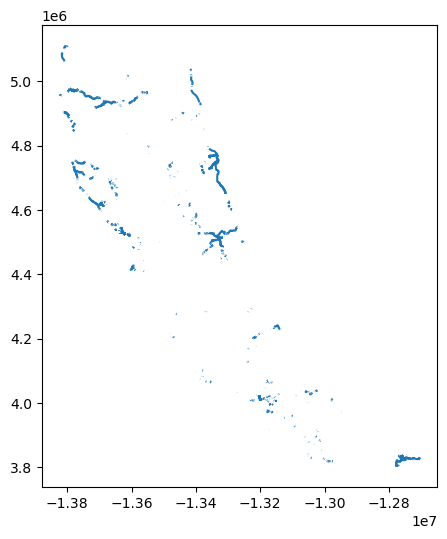

In [131]:
# Change to overlay later
(overlay_df.plot(figsize=(12, 6), markersize=30))

In [165]:
display(
    Markdown(
        f"""There are {overlay_df['route_id'].nunique()} routes (run by {overlay_df['agency'].nunique()} different agencies) 
        w/o overlap to the AT&T coverage map. In comparison, there are {routes_df2.route_id.nunique()} total routes in the original dataframe."""
    )
)

There are 297 routes (run by 98 different agencies) 
        w/o overlap to the AT&T coverage map. In comparison, there are 1709 total routes in the original dataframe.

In [133]:
# Previewing the routes left
# overlay_df[cols_without_geometry].sort_values('route_name')

In [142]:
# Agencies with the most routes without coverage.
(
    overlay_df.groupby(["agency"])
    .agg({"route_id": "nunique"})
    .rename(columns={"route_id": "total_routes"})
    .sort_values("total_routes", ascending=False)
    .head(10)
)

,total_routes
agency,
AC Transit,34
Metro,32
Marin Transit,18
Los Angeles Department of Transportation,13
Golden Gate Bridge Highway and Transportation District,13
North County Transit District,10
San Diego Metropolitan Transit System,10
Yuma County Area Transit,9
Tahoe Transportation,9


In [146]:
# Surprised by AC Transit
# overlay_df.loc[overlay_df['agency']=='AC Transit']

## Trips
* How many trips are running for a route?

In [135]:
# List for unique itp_ids
agencies_no_coverage = overlay_df["itp_id"].unique().tolist()

In [155]:
# List for unique route ids
routes_no_coverage = overlay_df["route_id"].unique().tolist()

In [166]:
# A table with all the itp id & agencies
agency_df = overlay_df[["agency", "itp_id"]].drop_duplicates().reset_index()

In [137]:
itp_id = 4
analysis_date = dt.date(2022, 5, 25)

In [157]:
# From rt scheduled vs ran work notebook
# How to just filter for all the itp ids and all routes at once?
ac_transit = (
    tbl.views.gtfs_schedule_fact_daily_trips()
    >> filter(_.calitp_itp_id == itp_id)
    >> filter(_.service_date == analysis_date)
    >> filter(_.is_in_service == True)
    >> collect()
)

In [158]:
ac_transit2 = ac_transit[ac_transit["route_id"].isin(routes_no_coverage)]

In [159]:
ac_transit2.shape

(3282, 21)

In [173]:
ac_transit_summary = (
    ac_transit2.groupby(["route_id"])
    .agg({"trip_id": "count"})
    .reset_index()
    .rename(columns={"trip_id": "total_trips"})
)

In [175]:
ac_transit_summary.sort_values('total_trips', ascending = False)

,route_id,total_trips
13,40,392
15,6,360
0,10,258
2,14,248
3,18,214
9,33,210
5,20,154
11,36,148
32,86,142
1,12,140


In [140]:
overlay_df["route_id"] = overlay_df["route_id"].str.lower().str.strip()

#### Why there are less unique Route ID numbers in stops df compared with routes df? 

In [141]:
f"{stops_df2.route_id.nunique()} route ids in trip stops dataframe compared to {overlay_df.route_id.nunique()} route ids in the routes dataframe above...strange."

NameError: name 'stops_df2' is not defined

In [ ]:
# What the missing route ids?
routes_df_id = set(route_id_without_cell)

# Use original trip_stops df to find ids...do they even exist there?
trips_df_id = set(stops_df.route_id.unique().tolist())
routes_df_id - trips_df_id

In [ ]:
subset_stops = stops_df2[["agency", "stop_id", "stop_name", "route_name"]]

In [ ]:
total_stops_df = stops_df2.groupby(
    [
        "agency",
        "route_name",
    ]
).agg({"stop_name": "count"})

In [ ]:
len(total_stops_df)